In [4]:
pip install scikit-gstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.6/708.6 kB 2.6 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from skgstat import Variogram
from pykrige.ok import OrdinaryKriging



In [6]:
df=pd.read_parquet('../UP_DATA/main_data_cleaned_aryan2_up_data.parquet')

In [32]:
import pickle
with open('../avideep_code/data/final_lucknow_with_lat_long_station_timestamp_station_name_new_split_val.pkl', 'rb') as fp:
    data_luck = pickle.load(fp)
data_luck[0]['Image'].shape

data_luck=[[x['Meteo'][0],x['Meteo'][1],x['Meteo'][2],x['Meteo'][3],x['Meteo'][4],x['Timestamp'],x['PM25']] for x in data_luck]
data_luck=pd.DataFrame(data_luck)
data_luck.columns=['temp','rh','bp','latitude','longitude','timestamp','pm25']
data_luck['timestamp']=pd.to_datetime(data_luck['timestamp'])

se=data_luck.groupby(['latitude','longitude'])['temp'].count().reset_index().reset_index()[['index','latitude','longitude']]
se.columns=['sensor_id','latitude','longitude']
data_luck2=pd.merge(data_luck,se,on=['latitude','longitude'])

In [35]:
working_df_for_plot_one_timestamp=data_luck2[data_luck2.timestamp=='2022-12-07'].reset_index(drop=True)

In [36]:
working_df_for_plot_one_timestamp

,temp,rh,bp,latitude,longitude,timestamp,pm25,sensor_id
0,33.7800,32.196667,742.560000,26.870196,80.904134,2022-12-07,36.71,46
1,22.7225,56.206667,753.013333,26.870196,80.904134,2022-12-07,36.99,46
2,22.7225,56.206667,753.013333,26.870196,80.904134,2022-12-07,36.99,46
3,18.3925,57.285000,751.561667,26.833997,80.891736,2022-12-07,85.04,25
4,30.9500,55.000000,744.135000,27.001078,80.883727,2022-12-07,142.78,70
5,30.9500,55.000000,744.135000,26.871664,80.882087,2022-12-07,171.03,47
6,33.1725,58.276667,743.421667,26.751549,81.157673,2022-12-07,33.16,9
7,30.1875,50.128333,745.485000,26.886549,80.860846,2022-12-07,28.62,53
8,30.1875,50.128333,745.485000,26.821692,80.920193,2022-12-07,36.85,22
9,30.1875,50.128333,745.485000,26.821692,80.920193,2022-12-07,36.85,22


In [44]:
df_ts = working_df_for_plot_one_timestamp.copy()
coords = df_ts[['longitude', 'latitude']].values
values = df_ts['pm25'].values


Parameters: [32170.38956148841, 1072.4766731157451, 1088.7309672949987]


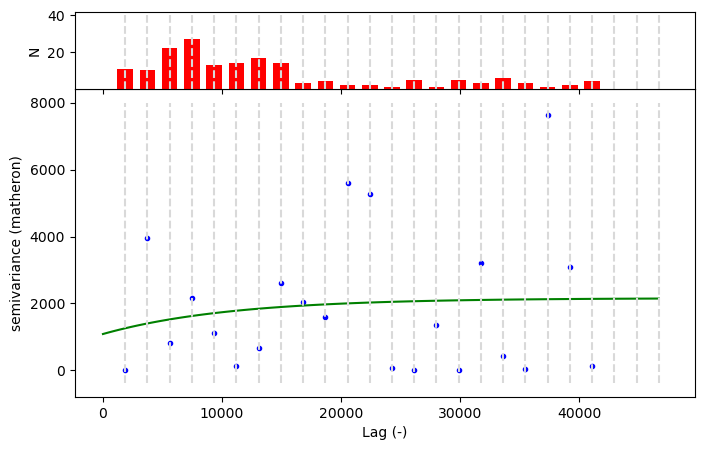

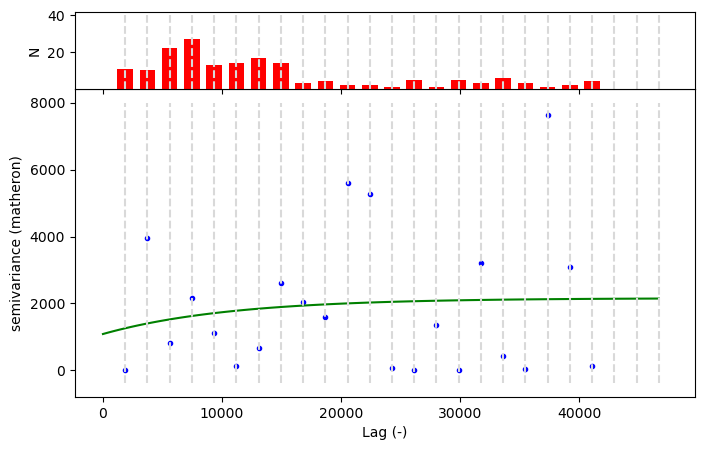

Parameters: [41001.36854642605, 794.483911296814, 1395.48421387783]


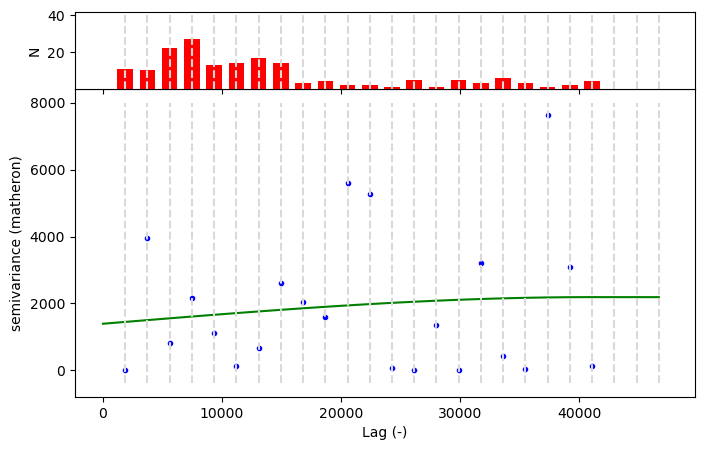

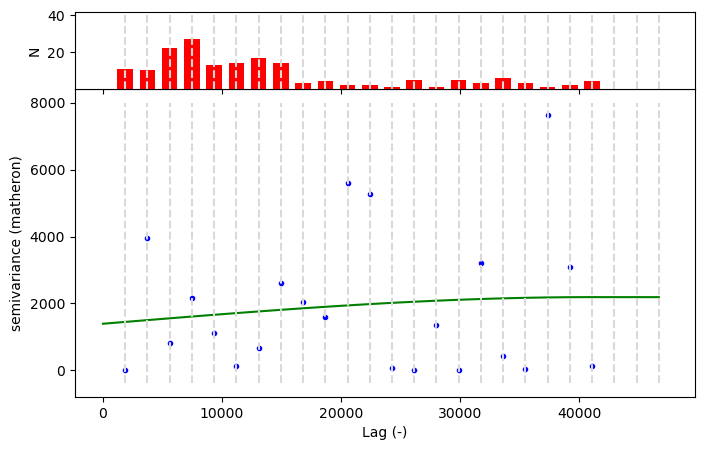

In [50]:
from skgstat import Variogram


gdf = gpd.GeoDataFrame(df_ts, geometry=gpd.points_from_xy(df_ts.longitude, df_ts.latitude), crs="EPSG:4326")
gdf_proj = gdf.to_crs("EPSG:32644")   # UTM Zone 44N (covers UP)

coords = np.array([(p.x, p.y) for p in gdf_proj.geometry])
values = gdf_proj["pm25"].values

# Fit variogram
V = Variogram(coords, values, model="spherical", n_lags=25, use_nugget=True, normalize=False)
print("Parameters:", V.parameters)   # nugget, sill, range
V.plot()





In [ ]:
lons = df_ts['longitude'].values
lats = df_ts['latitude'].values

OK = OrdinaryKriging(
    lons, lats, values,
    variogram_model='spherical',
    variogram_parameters=V.parameters,
    verbose=True, enable_plotting=False
)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 39605.884332548216
Full Sill: 41001.36854642605
Range: 794.483911296814
Nugget: 1395.48421387783 

Calculating statistics on variogram model fit...


25.70256058

Executing Ordinary Kriging...



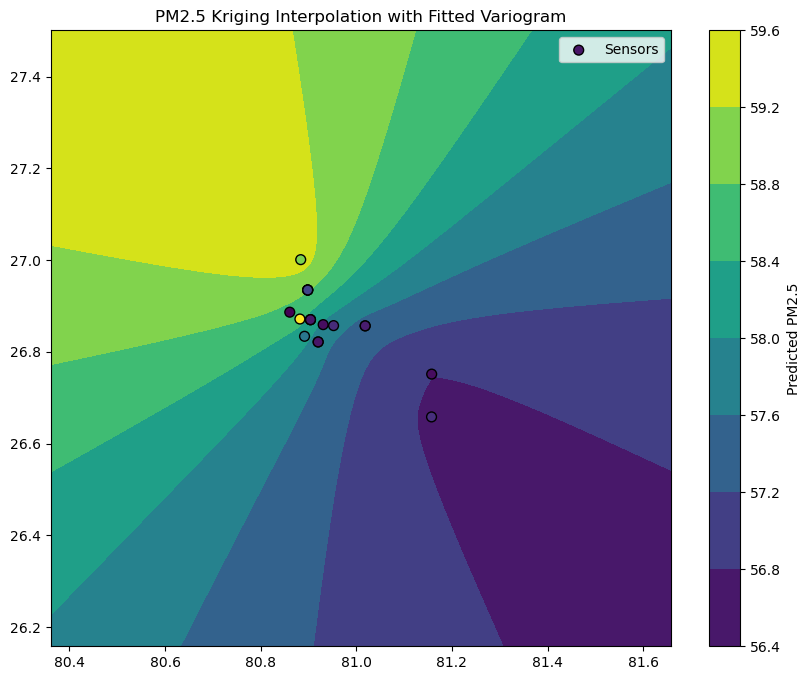

In [52]:
# make grid like xgb
LAT_MIN, LAT_MAX = df_ts['latitude'].min()-0.5,df_ts['latitude'].max()+0.5
LON_MIN, LON_MAX = df_ts['longitude'].min()-0.5,df_ts['longitude'].max()+0.5
grid_lon = np.linspace(LON_MIN, LON_MAX, 200)
grid_lat = np.linspace(LAT_MIN, LAT_MAX, 200)

z, ss = OK.execute("grid", grid_lon, grid_lat)

plt.figure(figsize=(10,8))
plt.contourf(grid_lon, grid_lat, z, cmap="viridis")
plt.colorbar(label="Predicted PM2.5")
plt.scatter(lons, lats, c=values, cmap="viridis", edgecolor="k", s=50, label="Sensors")
plt.title("PM2.5 Kriging Interpolation with Fitted Variogram")
plt.legend()
plt.show()


Executing Ordinary Kriging...



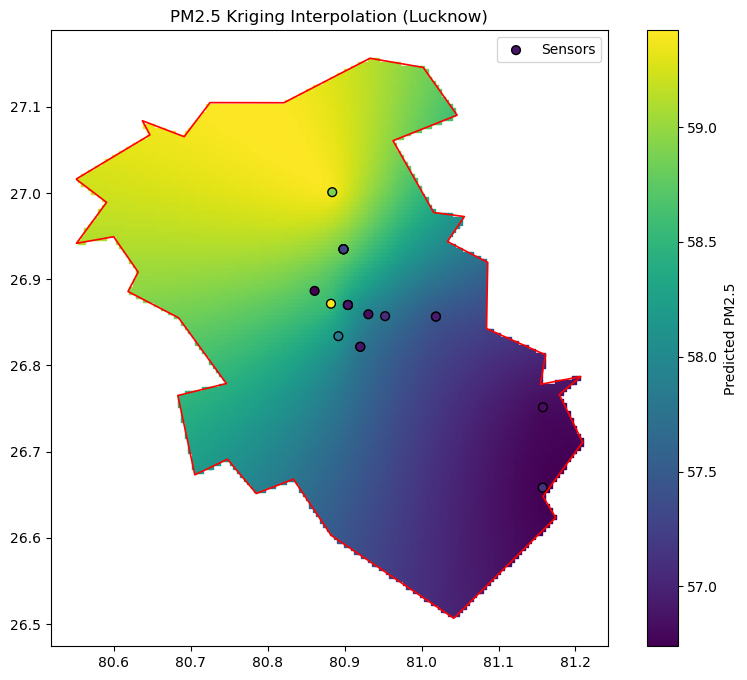

In [55]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

# make comparable charts for xgb model vs rt-rf-cnn
up_districts = gpd.read_file("up_districts.geojson")



selected = "Lucknow" 
if selected:
    boundary = up_districts[up_districts["id"] == selected]
else:
    boundary = up_districts

lats = df_ts["latitude"].values
lons = df_ts["longitude"].values
values = df_ts["pm25"].values



LAT_MIN, LAT_MAX = boundary.total_bounds[1], boundary.total_bounds[3]
LON_MIN, LON_MAX = boundary.total_bounds[0], boundary.total_bounds[2]

GRID_STEP = 0.0045  # 500m x 500 m grid as per the paper we need
grid_lon = np.arange(LON_MIN, LON_MAX, GRID_STEP)
grid_lat = np.arange(LAT_MIN, LAT_MAX, GRID_STEP)


z, ss = OK.execute("grid", grid_lon, grid_lat) # previous model OK

import pandas as pd
from shapely.geometry import Point

xx, yy = np.meshgrid(grid_lon, grid_lat)
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_values = z.ravel()

grid_gdf = gpd.GeoDataFrame(
    pd.DataFrame({"pm25": grid_values}),
    geometry=[Point(xy) for xy in grid_points],
    crs="EPSG:4326"
)

grid_clipped = gpd.sjoin(grid_gdf, boundary, predicate="within")

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    grid_clipped.geometry.x,
    grid_clipped.geometry.y,
    c=grid_clipped["pm25"],
    cmap="viridis",
    s=8,
    marker="s" 
)
plt.colorbar(sc, label="Predicted PM2.5")

boundary.boundary.plot(ax=plt.gca(), color="red", linewidth=1.2)
plt.scatter(lons, lats, c=values, cmap="viridis", edgecolor="k", s=40, label="Sensors")

plt.title(f"PM2.5 Kriging Interpolation ({selected if selected else 'All UP'})")
plt.legend()
plt.show()


In [63]:
grid_clipped["longitude"] = grid_clipped["geometry"].apply(lambda p: p.x)
grid_clipped["latitude"] = grid_clipped["geometry"].apply(lambda p: p.y)

In [65]:
grid_clipped

,pm25,geometry,index_right,id,d_id_11,Country,Name,Admin,State,longitude,latitude
255,57.011734,POINT (81.03667 26.51122),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,81.036667,26.511221
256,57.002025,POINT (81.04117 26.51122),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,81.041167,26.511221
257,56.992451,POINT (81.04567 26.51122),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,81.045667,26.511221
400,57.031619,POINT (81.02767 26.51572),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,81.027667,26.515721
401,57.021546,POINT (81.03217 26.51572),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,81.032167,26.515721
...,...,...,...,...,...,...,...,...,...,...,...
21113,59.022554,POINT (80.96467 27.15022),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,80.964667,27.150221
21114,59.005791,POINT (80.96917 27.15022),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,80.969167,27.150221
21253,59.133880,POINT (80.93317 27.15472),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,80.933167,27.154721
21254,59.119017,POINT (80.93767 27.15472),45,Lucknow,538,INDIA,Lucknow,Gaurav Sahu,Uttar Pradesh,80.937667,27.154721


In [66]:
from scipy.spatial import cKDTree
grid_coords = grid_clipped[['latitude','longitude']].values
tree = cKDTree(grid_coords)

sensor_coords = df_ts[['latitude','longitude']].values
distances, indices = tree.query(sensor_coords, k=1)
working_df_for_plot_one_timestamp = df_ts.copy()
working_df_for_plot_one_timestamp['nearest_grid_lat'] = grid_clipped.iloc[indices]['latitude'].values
working_df_for_plot_one_timestamp['nearest_grid_lon'] = grid_clipped.iloc[indices]['longitude'].values
working_df_for_plot_one_timestamp['nearest_grid_pm25_pred'] = grid_clipped.iloc[indices]['pm25'].values
working_df_for_plot_one_timestamp['dist_to_grid'] = distances  # in degrees if coords are lat/lon
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
print('RMSE for grid prediction at sensor location',root_mean_squared_error(working_df_for_plot_one_timestamp['pm25'],working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']))
print('MAPE for grid prediction at sensor location',mean_absolute_percentage_error(working_df_for_plot_one_timestamp['pm25'],working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']))
np.abs(working_df_for_plot_one_timestamp['pm25']-working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']).describe()

RMSE for grid prediction at sensor location 36.73180940053682
MAPE for grid prediction at sensor location 0.4499413972161153


count     19.000000
mean      25.455127
std       27.207009
min        1.177908
25%       10.582773
50%       20.936126
75%       23.986150
max      112.494357
dtype: float64

# try Universal Kriging for spatial trends

In [ ]:
# we use same variogram

In [72]:
from pykrige.uk import UniversalKriging

UK = UniversalKriging(
    lons, lats, values,
    variogram_model="spherical",
    variogram_parameters=V.parameters,
    drift_terms=["quadratic"]   # options: 'constant', 'regional_linear', 'quadratic'
)

z, ss = UK.execute("grid", grid_lon, grid_lat)

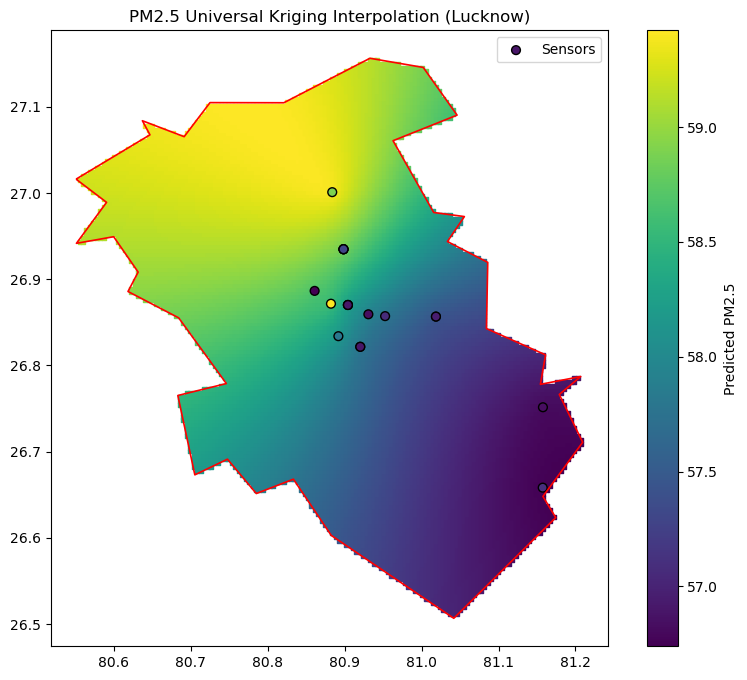

RMSE for grid prediction at sensor location 36.73180940053682
MAPE for grid prediction at sensor location 0.4499413972161153


count     19.000000
mean      25.455127
std       27.207009
min        1.177908
25%       10.582773
50%       20.936126
75%       23.986150
max      112.494357
dtype: float64

In [73]:

# make comparable charts for xgb model vs rt-rf-cnn
up_districts = gpd.read_file("up_districts.geojson")
selected = "Lucknow" 
if selected:
    boundary = up_districts[up_districts["id"] == selected]
else:
    boundary = up_districts

lats = df_ts["latitude"].values
lons = df_ts["longitude"].values
values = df_ts["pm25"].values

LAT_MIN, LAT_MAX = boundary.total_bounds[1], boundary.total_bounds[3]
LON_MIN, LON_MAX = boundary.total_bounds[0], boundary.total_bounds[2]

GRID_STEP = 0.0045  # 500m x 500 m grid as per the paper we need
grid_lon = np.arange(LON_MIN, LON_MAX, GRID_STEP)
grid_lat = np.arange(LAT_MIN, LAT_MAX, GRID_STEP)


z, ss = UK.execute("grid", grid_lon, grid_lat) # previous model OK

import pandas as pd
from shapely.geometry import Point

xx, yy = np.meshgrid(grid_lon, grid_lat)
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_values = z.ravel()

grid_gdf = gpd.GeoDataFrame(
    pd.DataFrame({"pm25": grid_values}),
    geometry=[Point(xy) for xy in grid_points],
    crs="EPSG:4326"
)

grid_clipped = gpd.sjoin(grid_gdf, boundary, predicate="within")

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    grid_clipped.geometry.x,
    grid_clipped.geometry.y,
    c=grid_clipped["pm25"],
    cmap="viridis",
    s=8,
    marker="s" 
)
plt.colorbar(sc, label="Predicted PM2.5")

boundary.boundary.plot(ax=plt.gca(), color="red", linewidth=1.2)
plt.scatter(lons, lats, c=values, cmap="viridis", edgecolor="k", s=40, label="Sensors")

plt.title(f"PM2.5 Universal Kriging Interpolation ({selected if selected else 'All UP'})")
plt.legend()
plt.show()

grid_clipped["longitude"] = grid_clipped["geometry"].apply(lambda p: p.x)
grid_clipped["latitude"] = grid_clipped["geometry"].apply(lambda p: p.y)
from scipy.spatial import cKDTree
grid_coords = grid_clipped[['latitude','longitude']].values
tree = cKDTree(grid_coords)

sensor_coords = df_ts[['latitude','longitude']].values
distances, indices = tree.query(sensor_coords, k=1)
working_df_for_plot_one_timestamp = df_ts.copy()
working_df_for_plot_one_timestamp['nearest_grid_lat'] = grid_clipped.iloc[indices]['latitude'].values
working_df_for_plot_one_timestamp['nearest_grid_lon'] = grid_clipped.iloc[indices]['longitude'].values
working_df_for_plot_one_timestamp['nearest_grid_pm25_pred'] = grid_clipped.iloc[indices]['pm25'].values
working_df_for_plot_one_timestamp['dist_to_grid'] = distances  # in degrees if coords are lat/lon
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
print('RMSE for grid prediction at sensor location',root_mean_squared_error(working_df_for_plot_one_timestamp['pm25'],working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']))
print('MAPE for grid prediction at sensor location',mean_absolute_percentage_error(working_df_for_plot_one_timestamp['pm25'],working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']))
np.abs(working_df_for_plot_one_timestamp['pm25']-working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']).describe()

# Try co kriging

In [76]:
import numpy as np
import pandas as pd
from pykrige.uk import UniversalKriging

x = df_ts["longitude"].values
y = df_ts["latitude"].values
z = df_ts["pm25"].values           # primary variable
drift = df_ts["temp"].values  # secondary variable

gridx = np.linspace(df_ts["longitude"].min(), df_ts["longitude"].max(), 50)
gridy = np.linspace(df_ts["latitude"].min(), df_ts["latitude"].max(), 50)


UK = UniversalKriging(
    x,
    y,
    z,
    variogram_model="linear",        # try 'spherical', 'exponential', 'gaussian'
    drift_terms=["external_drift"],
    external_drift=drift,            # drift at observation points
    external_drift_x=x,
    external_drift_y=y
)

# Make up drift values at grid points (must match grid shape!)
# Here, I simply interpolate elevation values using nearest neighbors
from scipy.interpolate import griddata
grid_drift = griddata(
    (x, y),
    drift,
    (np.meshgrid(gridx, gridy)[0], np.meshgrid(gridx, gridy)[1]),
    method="nearest"
)

# Execute kriging
z_pred, ss = UK.execute(
    "grid",
    gridx,
    gridy,
    grid_drift
)



Predicted PM2.5 grid: (50, 50)
Prediction variance grid: (50, 50)


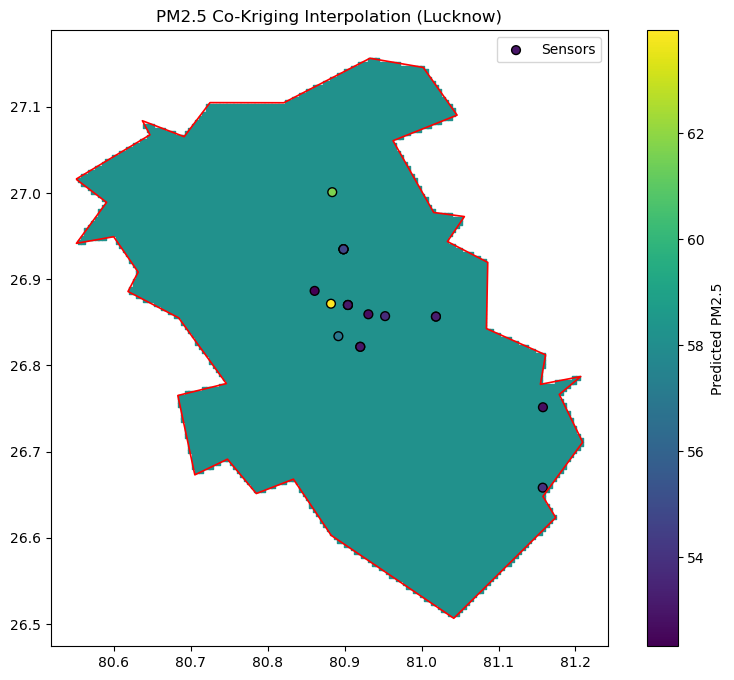

RMSE for grid prediction at sensor location 37.07078334536964
MAPE for grid prediction at sensor location 0.45613508448713963


count     19.000000
mean      25.782604
std       27.366348
min        0.471053
25%       11.246053
50%       21.141053
75%       24.751053
max      112.898947
dtype: float64

In [79]:

# make comparable charts for xgb model vs rt-rf-cnn
up_districts = gpd.read_file("up_districts.geojson")
selected = "Lucknow" 
if selected:
    boundary = up_districts[up_districts["id"] == selected]
else:
    boundary = up_districts

lats = df_ts["latitude"].values
lons = df_ts["longitude"].values
values = df_ts["pm25"].values
drift = df_ts["temp"].values  # secondary variable

LAT_MIN, LAT_MAX = boundary.total_bounds[1], boundary.total_bounds[3]
LON_MIN, LON_MAX = boundary.total_bounds[0], boundary.total_bounds[2]

GRID_STEP = 0.0045  # 500m x 500 m grid as per the paper we need
grid_lon = np.arange(LON_MIN, LON_MAX, GRID_STEP)
grid_lat = np.arange(LAT_MIN, LAT_MAX, GRID_STEP)
gx, gy = np.meshgrid(grid_lon, grid_lat)
from scipy.interpolate import griddata
grid_drift = griddata(
    (lons, lats),
    drift,
    (gx, gy),
    method="nearest"
)

z, ss = UK.execute("grid", grid_lon, grid_lat,grid_drift) # previous model OK

import pandas as pd
from shapely.geometry import Point

xx, yy = np.meshgrid(grid_lon, grid_lat)
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_values = z.ravel()

grid_gdf = gpd.GeoDataFrame(
    pd.DataFrame({"pm25": grid_values}),
    geometry=[Point(xy) for xy in grid_points],
    crs="EPSG:4326"
)

grid_clipped = gpd.sjoin(grid_gdf, boundary, predicate="within")

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    grid_clipped.geometry.x,
    grid_clipped.geometry.y,
    c=grid_clipped["pm25"],
    cmap="viridis",
    s=8,
    marker="s" 
)
plt.colorbar(sc, label="Predicted PM2.5")

boundary.boundary.plot(ax=plt.gca(), color="red", linewidth=1.2)
plt.scatter(lons, lats, c=values, cmap="viridis", edgecolor="k", s=40, label="Sensors")

plt.title(f"PM2.5 Co-Kriging Interpolation ({selected if selected else 'All UP'})")
plt.legend()
plt.show()

grid_clipped["longitude"] = grid_clipped["geometry"].apply(lambda p: p.x)
grid_clipped["latitude"] = grid_clipped["geometry"].apply(lambda p: p.y)
from scipy.spatial import cKDTree
grid_coords = grid_clipped[['latitude','longitude']].values
tree = cKDTree(grid_coords)

sensor_coords = df_ts[['latitude','longitude']].values
distances, indices = tree.query(sensor_coords, k=1)
working_df_for_plot_one_timestamp = df_ts.copy()
working_df_for_plot_one_timestamp['nearest_grid_lat'] = grid_clipped.iloc[indices]['latitude'].values
working_df_for_plot_one_timestamp['nearest_grid_lon'] = grid_clipped.iloc[indices]['longitude'].values
working_df_for_plot_one_timestamp['nearest_grid_pm25_pred'] = grid_clipped.iloc[indices]['pm25'].values
working_df_for_plot_one_timestamp['dist_to_grid'] = distances  # in degrees if coords are lat/lon
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
print('RMSE for grid prediction at sensor location',root_mean_squared_error(working_df_for_plot_one_timestamp['pm25'],working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']))
print('MAPE for grid prediction at sensor location',mean_absolute_percentage_error(working_df_for_plot_one_timestamp['pm25'],working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']))
np.abs(working_df_for_plot_one_timestamp['pm25']-working_df_for_plot_one_timestamp['nearest_grid_pm25_pred']).describe()